In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm
import statsmodels.formula.api as smf

import utils

In [2]:
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
data_folder = os.path.join(data_dir, exp)
figure_folder = os.path.join(data_dir, 'timing_analysis')
os.makedirs(figure_folder, exist_ok=True)
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/data/behavior_data/exp2
/Users/rebekahzhang/data/behavior_data/timing_analysis


In [3]:
# two_colors = plt.cm.viridis(np.linspace(0, 1, 2))
two_colors = ["#ffb400", "#9080ff"]
custom_palette = {'s': two_colors[0], 'l': two_colors[1]}

In [4]:
sessions_training = utils.load_session_log(data_folder, f'sessions_training_{exp}.csv')

# Make df

### make bg_vs_tw df

In [18]:
trials_training = utils.load_data(os.path.join(data_folder, 'trials_training_filtered2.csv'))

In [19]:
# Find outlier trials for bg_length in each group using z-score threshold
def get_outlier_indices(series, z_thresh=3):
    z_scores = (series - series.mean()) / series.std()
    return series.index[abs(z_scores) >= z_thresh]

In [20]:
# get rid of missed trials
bg_vs_tw_raw = trials_training[trials_training['time_waited'].notna()].copy()
bg_vs_tw_raw = bg_vs_tw_raw.reset_index(drop=True)

# Now get outlier indices - these will be based on the new unique index
bg_length_s = bg_vs_tw_raw.loc[bg_vs_tw_raw['group'] == 's', 'bg_length']
outlier_indices_s = get_outlier_indices(bg_length_s)
bg_length_l = bg_vs_tw_raw.loc[bg_vs_tw_raw['group'] == 'l', 'bg_length']
outlier_indices_l = get_outlier_indices(bg_length_l)

# Remove outlier trials from bg_vs_tw using outlier_indices_s and outlier_indices_l
outlier_indices = outlier_indices_s.union(outlier_indices_l)
bg_vs_tw = bg_vs_tw_raw.drop(index=outlier_indices)

bg_vs_tw['bg_length_rounded'] = bg_vs_tw['bg_length'].round(1)
bg_vs_tw['period'] = bg_vs_tw['session']//10

# Keep the index reset at the end too
bg_vs_tw = bg_vs_tw.reset_index(drop=True)

In [22]:
utils.save_as_csv(bg_vs_tw, data_folder, 'trials_bg_vs_tw_analysis.csv')

# Load data and basic stats

In [23]:
bg_vs_tw = utils.load_data(os.path.join(data_folder, 'trials_bg_vs_tw_analysis.csv'))

# plotted plots

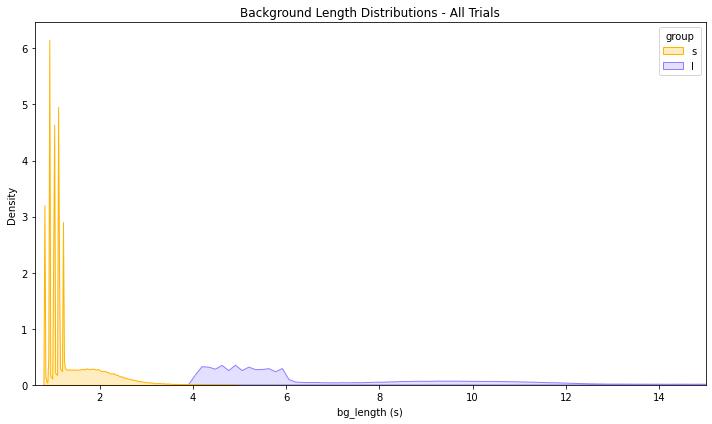

In [24]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=bg_vs_tw,
    x='bg_length',
    hue='group',
    palette=custom_palette,
    common_norm=False,
    fill=True,
    bw_adjust=0.1
)
plt.xlabel('bg_length (s)')
plt.xlim((0.6,15))
plt.ylabel('Density')
plt.title('Background Length Distributions - All Trials')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "kde_bg_length_by_group.png"))

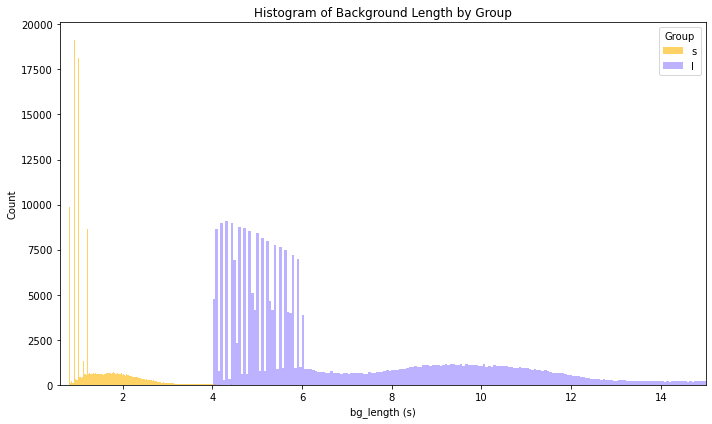

In [25]:
plt.figure(figsize=(10, 6))
for group in ['s', 'l']:
    plt.hist(
        bg_vs_tw[bg_vs_tw['group'] == group]['bg_length'],
        bins=500,
        color=custom_palette[group],
        alpha=0.6,
        label=group
    )
plt.xlabel('bg_length (s)')
plt.xlim((0.6, 15))
plt.ylabel('Count')
plt.title('Histogram of Background Length by Group')
plt.legend(title='Group')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "hist_bg_length_by_group.png"))

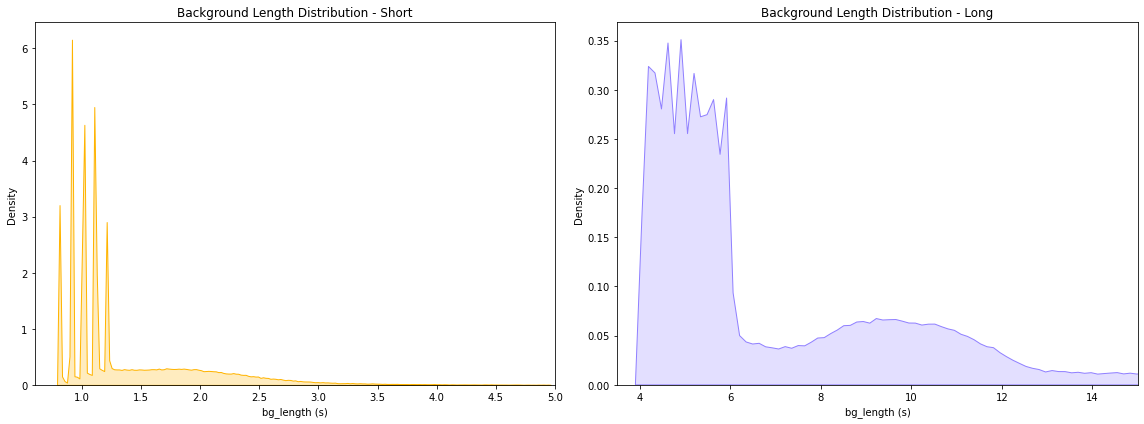

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Short group (left)
sns.kdeplot(
    data=bg_vs_tw[bg_vs_tw['group'] == 's'],
    x='bg_length',
    color=custom_palette['s'],
    common_norm=False,
    fill=True,
    bw_adjust=0.1,
    ax=axes[0]
)
axes[0].set_xlabel('bg_length (s)')
axes[0].set_xlim((0.6, 5))
axes[0].set_ylabel('Density')
axes[0].set_title('Background Length Distribution - Short')

# Long group (right)
sns.kdeplot(
    data=bg_vs_tw[bg_vs_tw['group'] == 'l'],
    x='bg_length',
    color=custom_palette['l'],
    common_norm=False,
    fill=True,
    bw_adjust=0.1,
    ax=axes[1]
)
axes[1].set_xlabel('bg_length (s)')
axes[1].set_xlim((3.5, 15))
axes[1].set_ylabel('Density')
axes[1].set_title('Background Length Distribution - Long')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "kde_bg_length_by_group_split.png"))

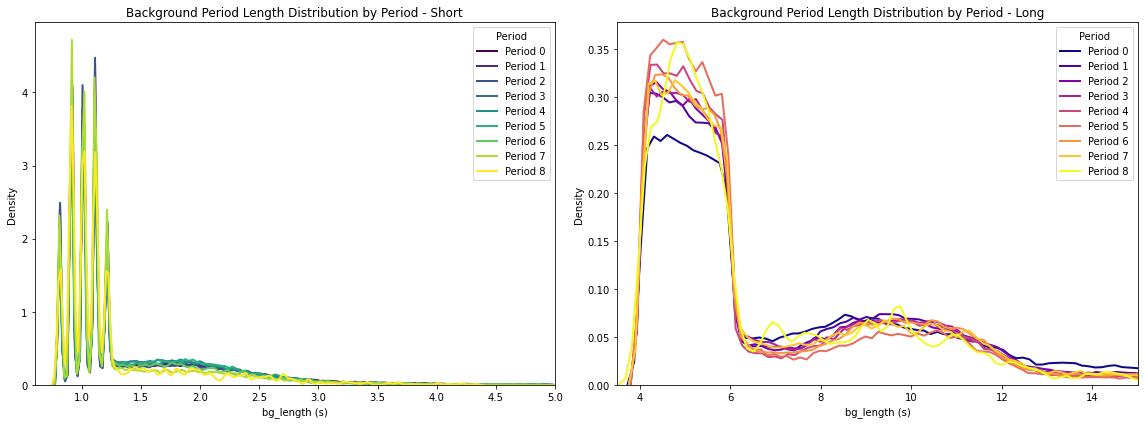

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

periods = sorted(bg_vs_tw['period'].unique())

# Plot for both groups in a loop to avoid code repetition
for i, group in enumerate(['s', 'l']):
    cmap = plt.cm.viridis if group == 's' else plt.cm.plasma
    group_data = bg_vs_tw[bg_vs_tw['group'] == group]
    for period in periods:
        period_data = group_data[group_data['period'] == period]
        if not period_data.empty:
            sns.kdeplot(
                data=period_data,
                x='bg_length',
                ax=axes[i],
                label=f'Period {period}',
                linewidth=2,
                bw_adjust=0.15,
                fill=False,
                color=cmap(period / max(periods))
            )
    axes[i].set_title(f'Background Period Length Distribution by Period - {"Short" if group == "s" else "Long"}')
    axes[i].set_xlabel('bg_length (s)')
    axes[i].set_xlim((0.6, 5) if group == 's' else (3.5, 15))
    axes[i].set_ylabel('Density')
    axes[i].legend(title='Period')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "kde_bg_length_by_period_short_long.png"))

In [28]:
bg_vs_tw_by_period = bg_vs_tw.sort_values('period').groupby('period')

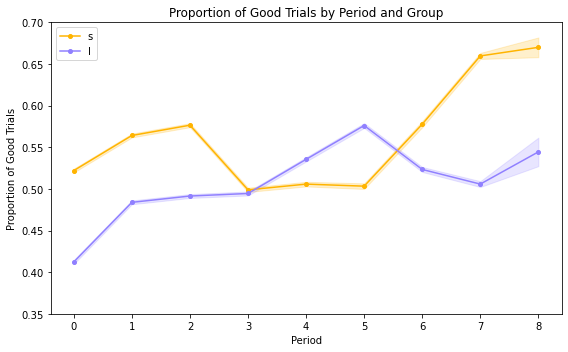

In [32]:
results = (
    bg_vs_tw.groupby(['period', 'group'])['good_trial']
    .agg(['mean', 'count'])
    .reset_index()
    .pivot(index='period', columns='group')
)

x_period = results.index.values
p_good_s = results['mean']['s'].values
p_good_l = results['mean']['l'].values
n_s = results['count']['s'].values
n_l = results['count']['l'].values

# Standard error for binomial proportion
p_good_err_s = np.sqrt(p_good_s * (1 - p_good_s) / n_s)
p_good_err_l = np.sqrt(p_good_l * (1 - p_good_l) / n_l)

plt.figure(figsize=(8, 5))
plt.plot(x_period, p_good_s, label='s', color=custom_palette['s'], marker='o', markersize=4)
plt.fill_between(
    x_period, p_good_s - p_good_err_s, p_good_s + p_good_err_s,
    color=custom_palette['s'], alpha=0.2
)
plt.plot(x_period, p_good_l, label='l', color=custom_palette['l'], marker='o', markersize=4)
plt.fill_between(
    x_period, p_good_l - p_good_err_l, p_good_l + p_good_err_l,
    color=custom_palette['l'], alpha=0.2
)
plt.xlabel('Period')
plt.ylabel('Proportion of Good Trials')
plt.title('Proportion of Good Trials by Period and Group')
plt.ylim(0.35, 0.7)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "proportion_good_trials_by_period_and_group.png"))

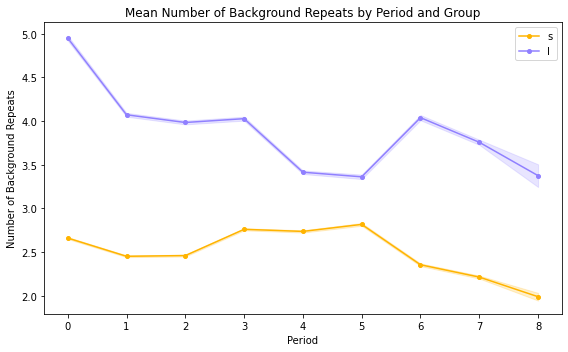

In [34]:
# Compute mean and standard error for bg_repeats by period and group in a single step
summary = (
    bg_vs_tw.groupby(['period', 'group'])['bg_repeats']
    .agg(['mean', 'count', 'std'])
    .reset_index()
    .pivot(index='period', columns='group')
)

x_period = summary.index.values
mean_bg_repeat_s = summary['mean']['s'].values
mean_bg_repeat_l = summary['mean']['l'].values
err_bg_repeat_s = summary['std']['s'].values / np.sqrt(summary['count']['s'].values)
err_bg_repeat_l = summary['std']['l'].values / np.sqrt(summary['count']['l'].values)

plt.figure(figsize=(8, 5))
plt.plot(
    x_period, mean_bg_repeat_s, label='s', color=custom_palette['s'],
    marker='o', markersize=4
)
plt.fill_between(
    x_period,
    mean_bg_repeat_s - err_bg_repeat_s,
    mean_bg_repeat_s + err_bg_repeat_s,
    color=custom_palette['s'], alpha=0.2
)
plt.plot(
    x_period, mean_bg_repeat_l, label='l', color=custom_palette['l'],
    marker='o', markersize=4
)
plt.fill_between(
    x_period,
    mean_bg_repeat_l - err_bg_repeat_l,
    mean_bg_repeat_l + err_bg_repeat_l,
    color=custom_palette['l'], alpha=0.2
)
plt.xlabel('Period')
plt.ylabel('Number of Background Repeats')
plt.title('Mean Number of Background Repeats by Period and Group')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "mean_bg_repeats_by_period_and_group.png"))

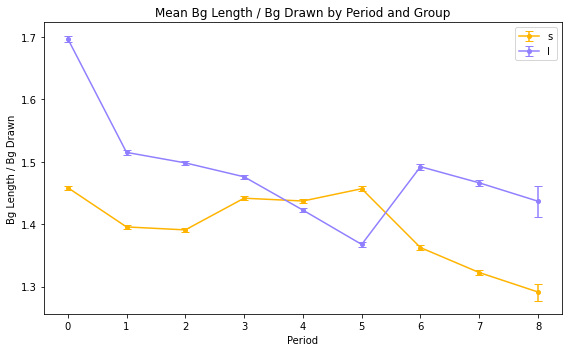

In [35]:
x_period = []
mean_drawn_over_len_s = []
mean_drawn_over_len_l = []
err_drawn_over_len_s = []
err_drawn_over_len_l = []

for p, period_data in bg_vs_tw_by_period:
    x_period.append(p)
    for group, y_list, err_list in zip(['s', 'l'], [mean_drawn_over_len_s, mean_drawn_over_len_l], [err_drawn_over_len_s, err_drawn_over_len_l]):
        group_data = period_data[period_data['group'] == group]
        # Compute the ratio for each trial
        ratio = group_data['bg_length'] / group_data['bg_drawn']
        mean_ratio = ratio.mean()
        se_ratio = ratio.std() / np.sqrt(len(ratio))
        y_list.append(mean_ratio)
        err_list.append(se_ratio)

plt.figure(figsize=(8, 5))
plt.errorbar(
    x_period, mean_drawn_over_len_s, yerr=err_drawn_over_len_s, label='s', color=custom_palette['s'],
    marker='o', capsize=4, markersize=4
)
plt.errorbar(
    x_period, mean_drawn_over_len_l, yerr=err_drawn_over_len_l, label='l', color=custom_palette['l'],
    marker='o', capsize=4, markersize=4
)
plt.xlabel('Period')
plt.ylabel('Bg Length / Bg Drawn')
plt.title('Mean Bg Length / Bg Drawn by Period and Group')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "mean_bg_length_bg_drawn_by_period_and_group.png"))

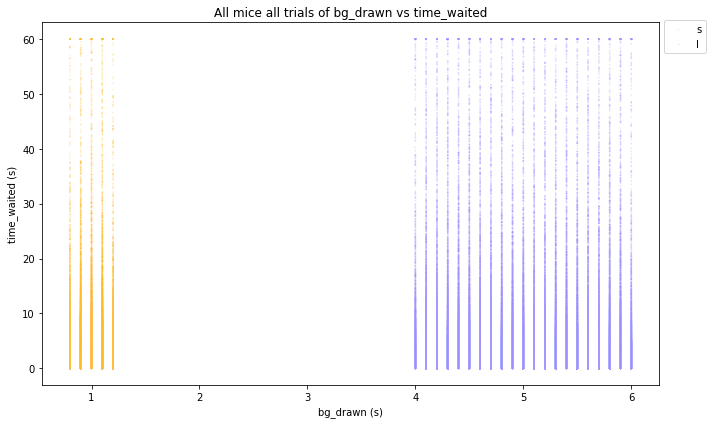

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=bg_vs_tw,
    x='bg_drawn',
    y='time_waited',
    hue='group',
    palette=custom_palette,
    s=3,
    alpha=0.2
)

plt.xlabel('bg_drawn (s)')
plt.ylabel('time_waited (s)')
plt.title('All mice all trials of bg_drawn vs time_waited')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "scatter_bg_drawn_vs_time_waited_all_mice_all_trials.png"))

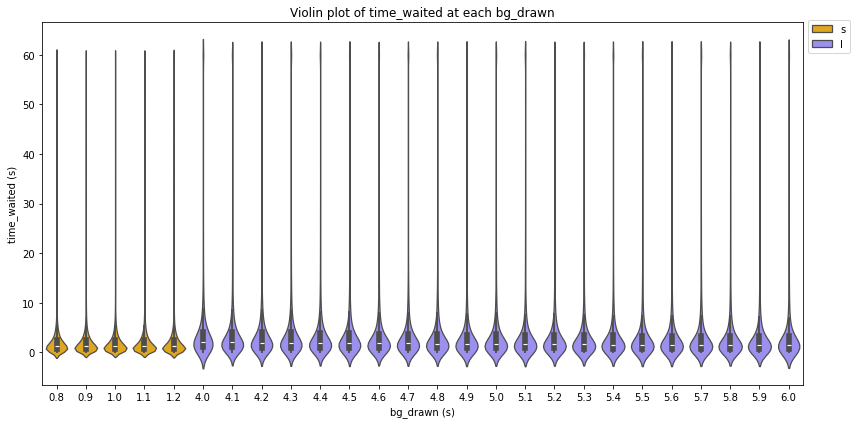

In [37]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='bg_drawn', y='time_waited', hue='group', data=bg_vs_tw, palette=custom_palette)
plt.xlabel('bg_drawn (s)')
plt.ylabel('time_waited (s)')
# plt.ylim((0, 10))
plt.title('Violin plot of time_waited at each bg_drawn')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "violin_bg_drawn_vs_time_waited_by_group_all.png"))

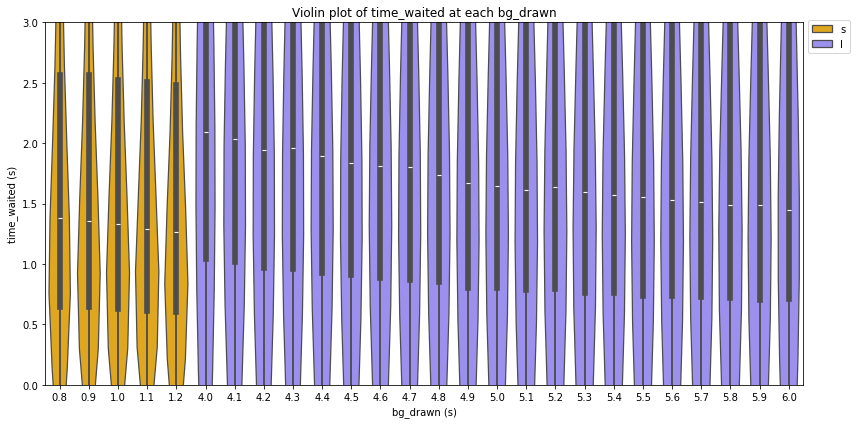

In [38]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='bg_drawn', y='time_waited', hue='group', data=bg_vs_tw, palette=custom_palette)
plt.xlabel('bg_drawn (s)')
plt.ylabel('time_waited (s)')
plt.ylim((0, 3))
plt.title('Violin plot of time_waited at each bg_drawn')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "violin_bg_drawn_vs_time_waited_by_group.png"))

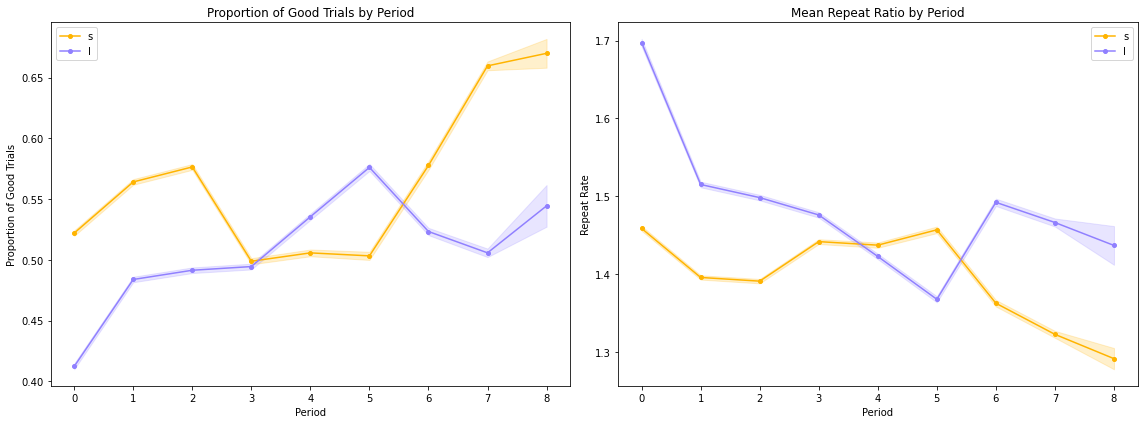

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Proportion of Good Trials
results = (
    bg_vs_tw.groupby(['period', 'group'])['good_trial']
    .agg(['mean', 'count'])
    .reset_index()
    .pivot(index='period', columns='group')
)

for group in ['s', 'l']:
    p_good = results['mean'][group].values
    n = results['count'][group].values
    p_err = np.sqrt(p_good * (1 - p_good) / n)
    x = results.index.values
    
    axes[0].plot(x, p_good, label=group, color=custom_palette[group], marker='o', markersize=4)
    axes[0].fill_between(x, p_good - p_err, p_good + p_err, color=custom_palette[group], alpha=0.2)

axes[0].set_xlabel('Period')
axes[0].set_ylabel('Proportion of Good Trials')
axes[0].set_title('Proportion of Good Trials by Period')
axes[0].legend()

# Right: Bg Length / Bg Drawn Ratio (with error as shading)
for group in ['s', 'l']:
    ratios = bg_vs_tw[bg_vs_tw['group'] == group].groupby('period').apply(
        lambda x: pd.Series({
            'mean': (x['bg_length'] / x['bg_drawn']).mean(),
            'err': (x['bg_length'] / x['bg_drawn']).std() / np.sqrt(len(x))
        })
    )
    x = ratios.index
    y = ratios['mean']
    yerr = ratios['err']
    axes[1].plot(x, y, label=group, color=custom_palette[group], marker='o', markersize=4)
    axes[1].fill_between(x, y - yerr, y + yerr, color=custom_palette[group], alpha=0.2)

axes[1].set_xlabel('Period')
axes[1].set_ylabel('Repeat Rate')
axes[1].set_title('Mean Repeat Ratio by Period')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "period_analysis_combined.png"))

In [39]:
# Mask for short and long groups
mask_s = bg_vs_tw['group'] == 's'
mask_l = bg_vs_tw['group'] == 'l'

# Linear regression
reg_s_drawn = linregress(bg_vs_tw.loc[mask_s, 'bg_drawn'], bg_vs_tw.loc[mask_s, 'time_waited'])
reg_l_drawn = linregress(bg_vs_tw.loc[mask_l, 'bg_drawn'], bg_vs_tw.loc[mask_l, 'time_waited'])

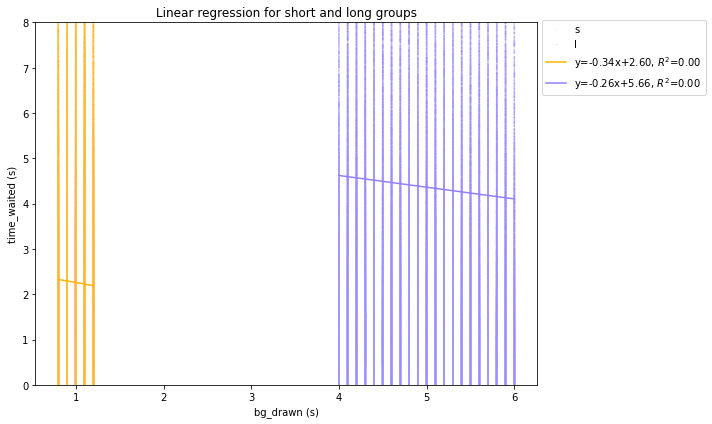

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=bg_vs_tw, x='bg_drawn', y='time_waited', hue='group',
    palette=custom_palette, s=3, alpha=0.2
)

# Regression lines
x_vals_s = np.linspace(bg_vs_tw.loc[mask_s, 'bg_drawn'].min(), bg_vs_tw.loc[mask_s, 'bg_drawn'].max(), 100)
x_vals_l = np.linspace(bg_vs_tw.loc[mask_l, 'bg_drawn'].min(), bg_vs_tw.loc[mask_l, 'bg_drawn'].max(), 100)
plt.plot(x_vals_s, reg_s_drawn.slope * x_vals_s + reg_s_drawn.intercept, color=custom_palette['s'], 
         label=f"y={reg_s_drawn.slope:.2f}x+{reg_s_drawn.intercept:.2f}, $R^2$={reg_s_drawn.rvalue**2:.2f}")
plt.plot(x_vals_l, reg_l_drawn.slope * x_vals_l + reg_l_drawn.intercept, color=custom_palette['l'], 
         label=f"y={reg_l_drawn.slope:.2f}x+{reg_l_drawn.intercept:.2f}, $R^2$={reg_l_drawn.rvalue**2:.2f}")

plt.xlabel('bg_drawn (s)')
plt.ylabel('time_waited (s)')
plt.ylim((0, 8))
plt.title('Linear regression for short and long groups')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "scatter_bg_drawn_vs_time_waited_with_regression.png"))

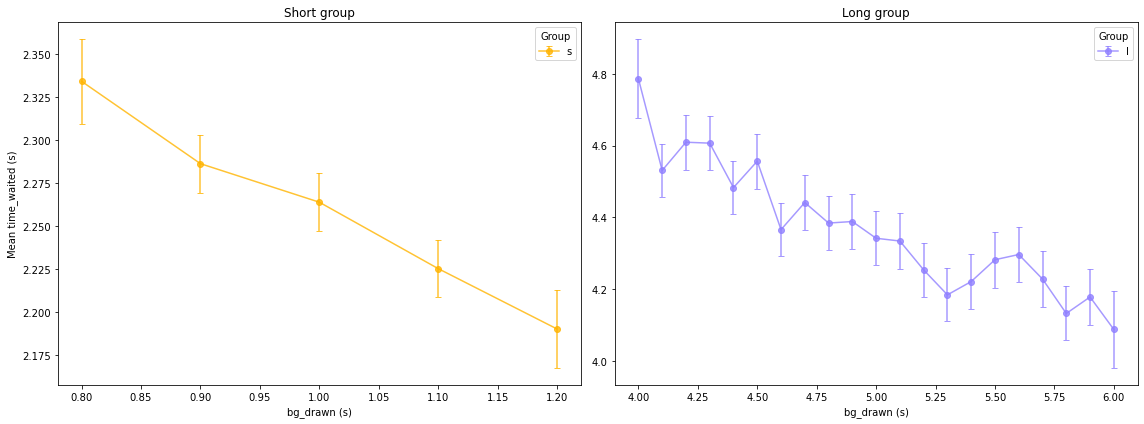

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

grouped = bg_vs_tw.groupby(['bg_drawn', 'group'])['time_waited']
mean = grouped.mean().reset_index()
sem = grouped.sem().reset_index()

# Short group (left)
grouped_s = mean[mean['group'] == 's']
grouped_sem_s = sem[sem['group'] == 's']
axes[0].errorbar(
    grouped_s['bg_drawn'],
    grouped_s['time_waited'],
    yerr=grouped_sem_s['time_waited'],
    label='s',
    color=custom_palette['s'],
    fmt='-o',
    capsize=3,
    alpha=0.8
)
axes[0].set_xlabel('bg_drawn (s)')
axes[0].set_ylabel('Mean time_waited (s)')
axes[0].set_title('Short group')
axes[0].legend(title='Group')

# Long group (right)
grouped_l = mean[mean['group'] == 'l']
grouped_sem_l = sem[sem['group'] == 'l']
axes[1].errorbar(
    grouped_l['bg_drawn'],
    grouped_l['time_waited'],
    yerr=grouped_sem_l['time_waited'],
    label='l',
    color=custom_palette['l'],
    fmt='-o',
    capsize=3,
    alpha=0.8
)
axes[1].set_xlabel('bg_drawn (s)')
axes[1].set_title('Long group')
axes[1].legend(title='Group')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lineplot_mean_time_waited_by_bg_drawn_grouped_split.png"))

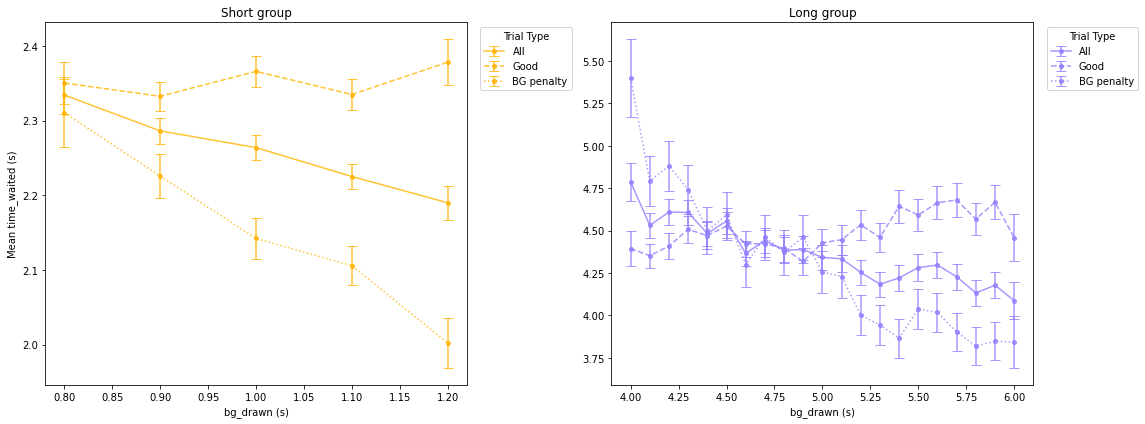

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, group in enumerate(['s', 'l']):
    # All trials
    grouped_all = bg_vs_tw[bg_vs_tw['group'] == group].groupby('bg_drawn')['time_waited']
    mean_all = grouped_all.mean()
    sem_all = grouped_all.sem()
    axes[i].errorbar(
        mean_all.index, mean_all.values, yerr=sem_all.values,
        label='All', color=custom_palette[group], fmt='-o', capsize=5, alpha=0.8, markersize=4
    )
    # Good trials
    grouped_good = bg_vs_tw[(bg_vs_tw['group'] == group) & (bg_vs_tw['good_trial'])].groupby('bg_drawn')['time_waited']
    mean_good = grouped_good.mean()
    sem_good = grouped_good.sem()
    axes[i].errorbar(
        mean_good.index, mean_good.values, yerr=sem_good.values,
        label='Good', color=custom_palette[group], fmt='--o', capsize=5, alpha=0.8, markersize=4
    )
    # Not good trials
    grouped_notgood = bg_vs_tw[(bg_vs_tw['group'] == group) & (~bg_vs_tw['good_trial'])].groupby('bg_drawn')['time_waited']
    mean_notgood = grouped_notgood.mean()
    sem_notgood = grouped_notgood.sem()
    axes[i].errorbar(
        mean_notgood.index, mean_notgood.values, yerr=sem_notgood.values,
        label='BG penalty', color=custom_palette[group], fmt=':o', capsize=5, alpha=0.8, markersize=4
    )
    axes[i].set_xlabel('bg_drawn (s)')
    axes[i].set_title('Short group' if group == 's' else 'Long group')
    # Place legend outside
    axes[i].legend(title='Trial Type', loc='upper left', bbox_to_anchor=(1.02, 1))

axes[0].set_ylabel('Mean time_waited (s)')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lineplot_mean_time_waited_by_bg_drawn_grouped_split_good_notgood.png"))


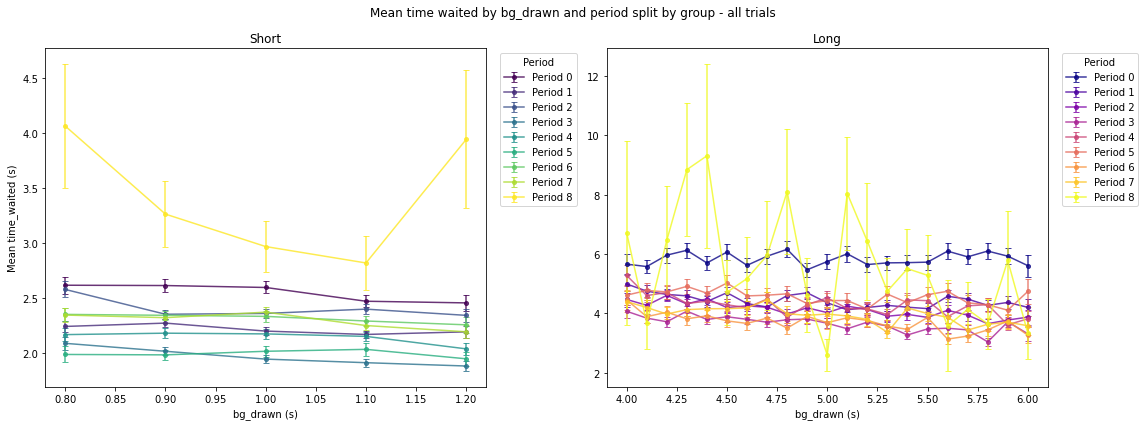

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, group in enumerate(['s', 'l']):
    # Use a gradient color palette for periods
    cmap = plt.cm.viridis if group == 's' else plt.cm.plasma
    for idx, period in enumerate(periods):
        period_data = bg_vs_tw[(bg_vs_tw['group'] == group) & (bg_vs_tw['period'] == period)]
        if not period_data.empty:
            grouped = period_data.groupby('bg_drawn')['time_waited']
            mean = grouped.mean()
            sem = grouped.sem()
            color = cmap(idx / (len(periods) - 1))
            axes[i].errorbar(
                mean.index, mean.values, yerr=sem.values,
                label=f'Period {period}',
                fmt='-o', capsize=3, alpha=0.8, markersize=4, color=color
            )
    axes[i].set_xlabel('bg_drawn (s)')
    axes[i].set_title('Short' if group == 's' else 'Long')
    axes[i].legend(title='Period', loc='upper left', bbox_to_anchor=(1.02, 1))
axes[0].set_ylabel('Mean time_waited (s)')
plt.suptitle('Mean time waited by bg_drawn and period split by group - all trials')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lineplot_mean_time_waited_by_bg_drawn_by_period_split.png"))

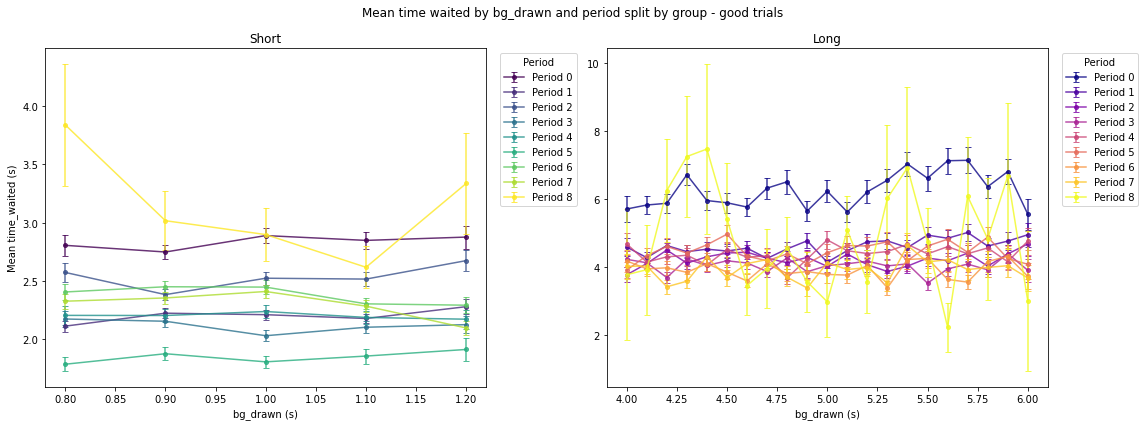

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, group in enumerate(['s', 'l']):
    # Use a gradient color palette for periods
    cmap = plt.cm.viridis if group == 's' else plt.cm.plasma
    for idx, period in enumerate(periods):
        period_data = bg_vs_tw[(bg_vs_tw['group'] == group) & (bg_vs_tw['period'] == period) & (bg_vs_tw['good_trial'] == True)]
        if not period_data.empty:
            grouped = period_data.groupby('bg_drawn')['time_waited']
            mean = grouped.mean()
            sem = grouped.sem()
            color = cmap(idx / (len(periods) - 1))
            axes[i].errorbar(
                mean.index, mean.values, yerr=sem.values,
                label=f'Period {period}',
                fmt='-o', capsize=3, alpha=0.8, markersize=4, color=color
            )
    axes[i].set_xlabel('bg_drawn (s)')
    axes[i].set_title('Short' if group == 's' else 'Long')
    axes[i].legend(title='Period', loc='upper left', bbox_to_anchor=(1.02, 1))
axes[0].set_ylabel('Mean time_waited (s)')
plt.suptitle('Mean time waited by bg_drawn and period split by group - good trials')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lineplot_mean_time_waited_by_bg_drawn_by_period_split_good_trials.png"))

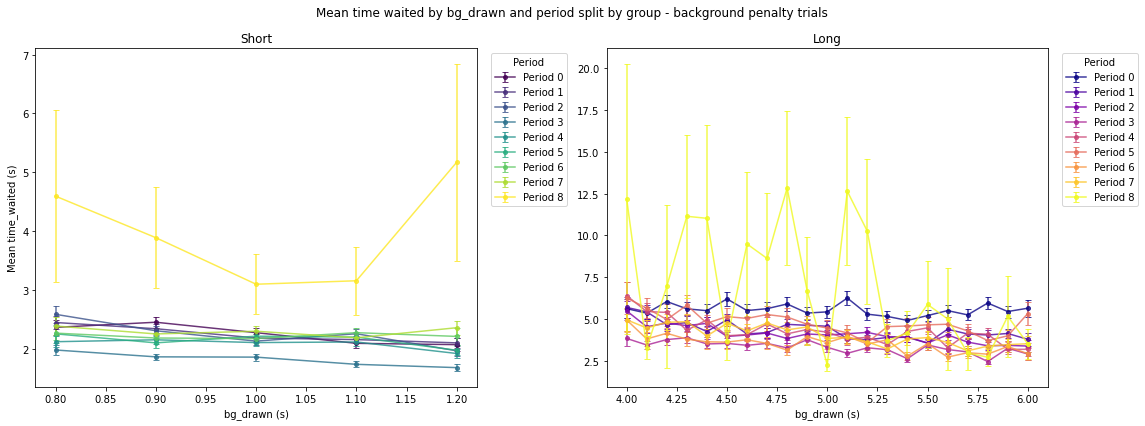

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, group in enumerate(['s', 'l']):
    # Use a gradient color palette for periods
    cmap = plt.cm.viridis if group == 's' else plt.cm.plasma
    for idx, period in enumerate(periods):
        period_data = bg_vs_tw[(bg_vs_tw['group'] == group) & (bg_vs_tw['period'] == period) & (bg_vs_tw['good_trial'] == False)]
        if not period_data.empty:
            grouped = period_data.groupby('bg_drawn')['time_waited']
            mean = grouped.mean()
            sem = grouped.sem()
            color = cmap(idx / (len(periods) - 1))
            axes[i].errorbar(
                mean.index, mean.values, yerr=sem.values,
                label=f'Period {period}',
                fmt='-o', capsize=3, alpha=0.8, markersize=4, color=color
            )
    axes[i].set_xlabel('bg_drawn (s)')
    axes[i].set_title('Short' if group == 's' else 'Long')
    axes[i].legend(title='Period', loc='upper left', bbox_to_anchor=(1.02, 1))
axes[0].set_ylabel('Mean time_waited (s)')
plt.suptitle('Mean time waited by bg_drawn and period split by group - background penalty trials')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lineplot_mean_time_waited_by_bg_drawn_by_period_split_not_good_trials.png"))

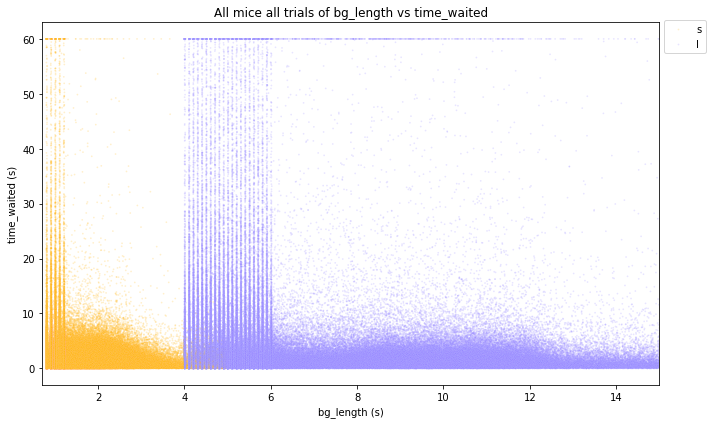

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=bg_vs_tw,
    x='bg_length',
    y='time_waited',
    hue='group',
    palette=custom_palette,
    s=3,
    alpha=0.2
)

plt.xlabel('bg_length (s)')
plt.xlim((0.7, 15))
plt.ylabel('time_waited (s)')
plt.title('All mice all trials of bg_length vs time_waited')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "scatter_bg_length_vs_time_waited_all_mice_all_trials.png"))

In [47]:
# Mask for short and long groups
mask_s = bg_vs_tw['group'] == 's'
mask_l = bg_vs_tw['group'] == 'l'

# Linear regression
reg_s_length = linregress(bg_vs_tw.loc[mask_s, 'bg_length'], bg_vs_tw.loc[mask_s, 'time_waited'])
reg_l_length = linregress(bg_vs_tw.loc[mask_l, 'bg_length'], bg_vs_tw.loc[mask_l, 'time_waited'])

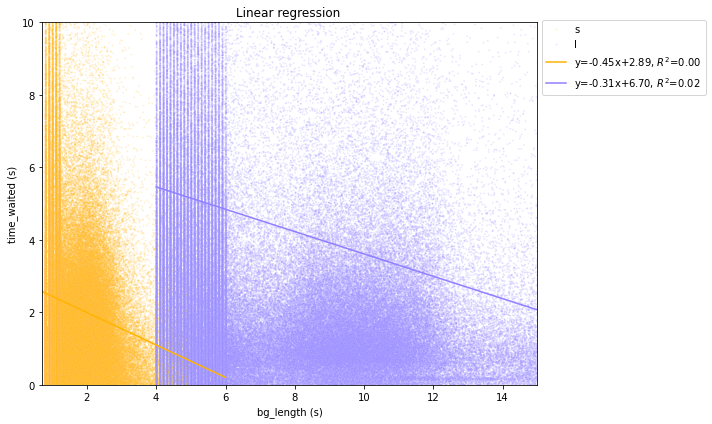

In [48]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=bg_vs_tw, x='bg_length', y='time_waited', hue='group',
    palette=custom_palette, s=3, alpha=0.2
)

# Regression lines between 0 and 10s
x_vals_s = np.linspace(0, 6, 60)
plt.plot(
    x_vals_s, reg_s_length.slope * x_vals_s + reg_s_length.intercept,
    color=custom_palette['s'],
    label=f"y={reg_s_length.slope:.2f}x+{reg_s_length.intercept:.2f}, $R^2$={reg_s_length.rvalue**2:.2f}"
)
x_vals_l = np.linspace(4, 15, 110)
plt.plot(
    x_vals_l, reg_l_length.slope * x_vals_l + reg_l_length.intercept,
    color=custom_palette['l'],
    label=f"y={reg_l_length.slope:.2f}x+{reg_l_length.intercept:.2f}, $R^2$={reg_l_length.rvalue**2:.2f}"
)

plt.xlabel('bg_length (s)')
plt.xlim((0.7, 15))
plt.ylabel('time_waited (s)')
plt.ylim((0, 10))
plt.title('Linear regression ')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "scatter_bg_length_vs_time_waited_with_regression_0_10s.png"))

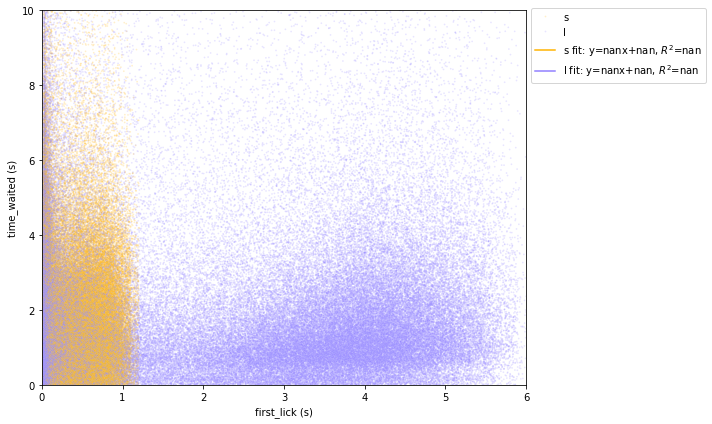

In [49]:
plt.figure(figsize=(10, 6))

# Reset index to avoid duplicate labels
filtered_data = bg_vs_tw[bg_vs_tw['good_trial']==False].reset_index(drop=True)

sns.scatterplot(
    data=filtered_data, x='first_lick', y='time_waited', hue='group',
    palette=custom_palette, s=3, alpha=0.2
)

# Linear regression for each group
for group in ['s', 'l']:
    mask = (bg_vs_tw['group'] == group) & (bg_vs_tw['good_trial'] == False)
    x = bg_vs_tw.loc[mask, 'first_lick']
    y = bg_vs_tw.loc[mask, 'time_waited']
    if len(x) > 1 and len(y) > 1:
        reg = linregress(x, y)
        x_vals = np.linspace(x.min(), x.max(), 100)
        plt.plot(
            x_vals, reg.slope * x_vals + reg.intercept,
            color=custom_palette[group],
            label=f"{group} fit: y={reg.slope:.2f}x+{reg.intercept:.2f}, $R^2$={reg.rvalue**2:.2f}"
        )


plt.xlabel('first_lick (s)')
plt.xlim((0, 6))
plt.ylabel('time_waited (s)')
plt.ylim((0, 10))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.tight_layout()
# plt.savefig(os.path.join(figure_folder, "scatter_first_lick_vs_time_waited_with_regression_0_10s.png"))

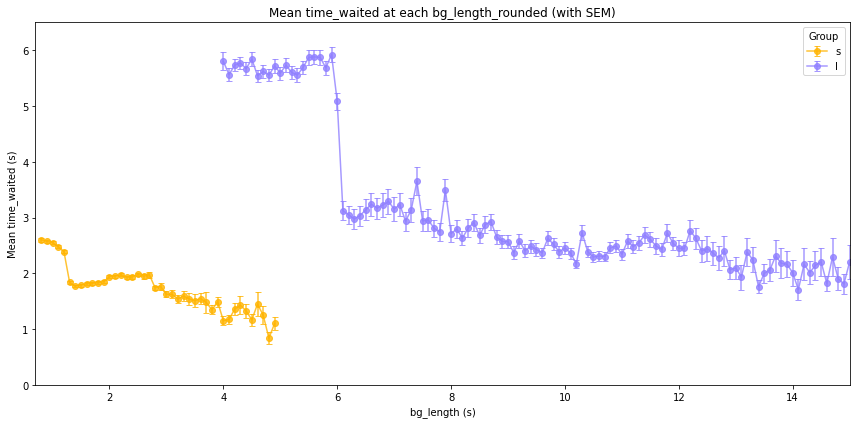

In [56]:
plt.figure(figsize=(12, 6))
grouped = bg_vs_tw.groupby(['bg_length_rounded', 'group'])['time_waited']
mean = grouped.mean().reset_index()
sem = grouped.sem().reset_index()

for group in ['s', 'l']:
    group_mean = mean[mean['group'] == group]
    group_sem = sem[sem['group'] == group]
    plt.errorbar(
        group_mean['bg_length_rounded'],
        group_mean['time_waited'],
        yerr=group_sem['time_waited'],
        label=group,
        color=custom_palette[group],
        fmt='-o',
        capsize=3,
        alpha=0.8
    )

plt.xlabel('bg_length (s)')
plt.ylabel('Mean time_waited (s)')
plt.title('Mean time_waited at each bg_length_rounded (with SEM)')
plt.legend(title='Group')
plt.xlim((0.7,15))
plt.ylim((0, 6.5))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lineplot_mean_time_waited_by_bg_length_rounded_cropped.png"))

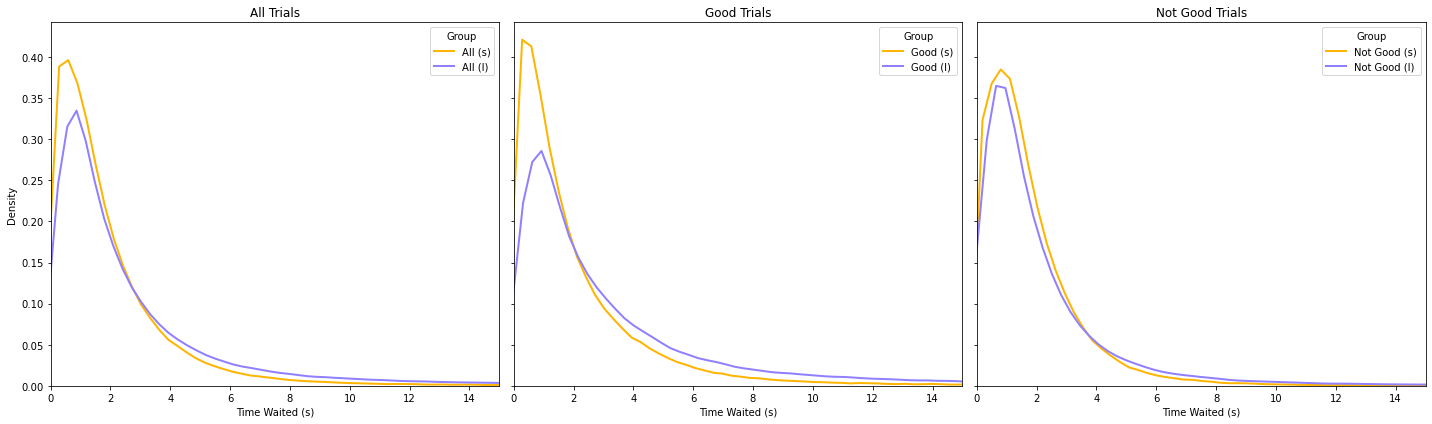

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# All trials
for group in ['s', 'l']:
    sns.kdeplot(
        data=bg_vs_tw[bg_vs_tw['group'] == group], x='time_waited',
        color=custom_palette[group], label=f'All ({group})',
        common_norm=False, fill=False, linewidth=2, bw_adjust=0.3, ax=axes[0]
    )
axes[0].set_title('All Trials')
axes[0].set_xlabel('Time Waited (s)')
axes[0].set_ylabel('Density')
axes[0].set_xlim((0, 15))
axes[0].legend(title='Group')

# Good trials
for group in ['s', 'l']:
    sns.kdeplot(
        data=bg_vs_tw[(bg_vs_tw['group'] == group) & (bg_vs_tw['good_trial'])], x='time_waited',
        color=custom_palette[group], label=f'Good ({group})',
        common_norm=False, fill=False, linewidth=2, bw_adjust=0.3, ax=axes[1]
    )
axes[1].set_title('Good Trials')
axes[1].set_xlabel('Time Waited (s)')
axes[1].set_xlim((0, 15))
axes[1].legend(title='Group')

# Not good trials
for group in ['s', 'l']:
    sns.kdeplot(
        data=bg_vs_tw[(bg_vs_tw['group'] == group) & (~bg_vs_tw['good_trial'])], x='time_waited',
        color=custom_palette[group], label=f'Not Good ({group})',
        common_norm=False, fill=False, linewidth=2, bw_adjust=0.3, ax=axes[2]
    )
axes[2].set_title('Not Good Trials')
axes[2].set_xlabel('Time Waited (s)')
axes[2].set_xlim((0, 15))
axes[2].legend(title='Group')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "kde_time_waited_all_good_notgood_by_group.png"))

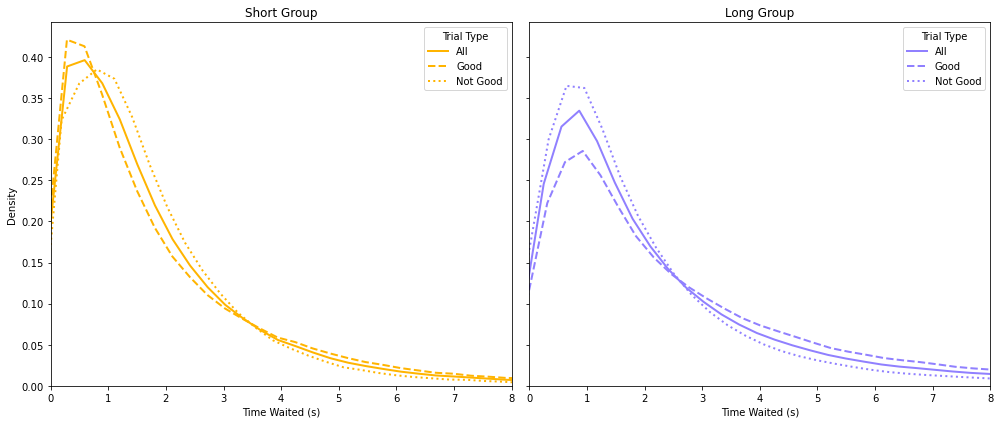

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Short group
for mask, label, style in [
    (bg_vs_tw['group'] == 's', 'All', 'solid'),
    ((bg_vs_tw['group'] == 's') & (bg_vs_tw['good_trial']), 'Good', 'dashed'),
    ((bg_vs_tw['group'] == 's') & (~bg_vs_tw['good_trial']), 'Not Good', 'dotted')
]:
    sns.kdeplot(
        data=bg_vs_tw[mask], x='time_waited',
        color=custom_palette['s'], label=label,
        common_norm=False, fill=False, linewidth=2, bw_adjust=0.3, ax=axes[0], linestyle=style
    )
axes[0].set_title('Short Group')
axes[0].set_xlabel('Time Waited (s)')
axes[0].set_ylabel('Density')
axes[0].set_xlim((0, 8))
axes[0].legend(title='Trial Type')

# Long group
for mask, label, style in [
    (bg_vs_tw['group'] == 'l', 'All', 'solid'),
    ((bg_vs_tw['group'] == 'l') & (bg_vs_tw['good_trial']), 'Good', 'dashed'),
    ((bg_vs_tw['group'] == 'l') & (~bg_vs_tw['good_trial']), 'Not Good', 'dotted')
]:
    sns.kdeplot(
        data=bg_vs_tw[mask], x='time_waited',
        color=custom_palette['l'], label=label,
        common_norm=False, fill=False, linewidth=2, bw_adjust=0.3, ax=axes[1], linestyle=style
    )
axes[1].set_title('Long Group')
axes[1].set_xlabel('Time Waited (s)')
axes[1].set_xlim((0, 8))
axes[1].legend(title='Trial Type')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "kde_time_waited_short_long_all_good_notgood.png"))


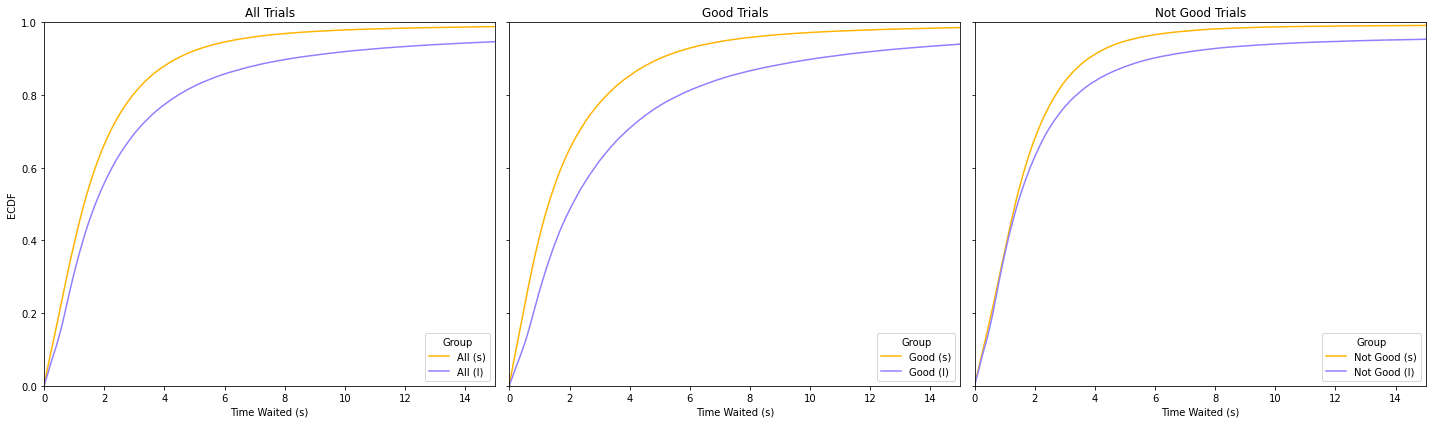

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# All trials ECDF
for group in ['s', 'l']:
    sns.ecdfplot(
        data=bg_vs_tw[bg_vs_tw['group'] == group], x='time_waited',
        color=custom_palette[group], label=f'All ({group})', ax=axes[0]
    )
axes[0].set_title('All Trials')
axes[0].set_xlabel('Time Waited (s)')
axes[0].set_ylabel('ECDF')
axes[0].set_xlim((0, 15))
axes[0].legend(title='Group', loc='lower right')

# Good trials ECDF
for group in ['s', 'l']:
    sns.ecdfplot(
        data=bg_vs_tw[(bg_vs_tw['group'] == group) & (bg_vs_tw['good_trial'])], x='time_waited',
        color=custom_palette[group], label=f'Good ({group})', ax=axes[1]
    )
axes[1].set_title('Good Trials')
axes[1].set_xlabel('Time Waited (s)')
axes[1].set_xlim((0, 15))
axes[1].legend(title='Group', loc='lower right')

# Not good trials ECDF
for group in ['s', 'l']:
    sns.ecdfplot(
        data=bg_vs_tw[(bg_vs_tw['group'] == group) & (~bg_vs_tw['good_trial'])], x='time_waited',
        color=custom_palette[group], label=f'Not Good ({group})', ax=axes[2]
    )
axes[2].set_title('Not Good Trials')
axes[2].set_xlabel('Time Waited (s)')
axes[2].set_xlim((0, 15))
axes[2].legend(title='Group', loc='lower right')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "ecdf_time_waited_all_good_notgood_by_group.png"))

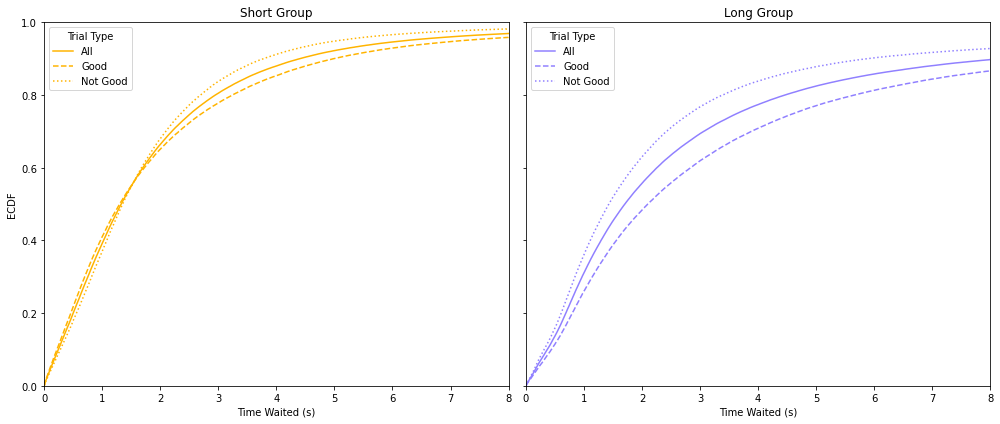

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Short group
for mask, label, style in [
    (bg_vs_tw['group'] == 's', 'All', 'solid'),
    ((bg_vs_tw['group'] == 's') & (bg_vs_tw['good_trial']), 'Good', 'dashed'),
    ((bg_vs_tw['group'] == 's') & (~bg_vs_tw['good_trial']), 'Not Good', 'dotted')
]:
    sns.ecdfplot(
        data=bg_vs_tw[mask], x='time_waited',
        color=custom_palette['s'], label=label,
        ax=axes[0], linestyle=style
    )
axes[0].set_title('Short Group')
axes[0].set_xlabel('Time Waited (s)')
axes[0].set_ylabel('ECDF')
axes[0].set_xlim((0, 8))
axes[0].legend(title='Trial Type')

# Long group
for mask, label, style in [
    (bg_vs_tw['group'] == 'l', 'All', 'solid'),
    ((bg_vs_tw['group'] == 'l') & (bg_vs_tw['good_trial']), 'Good', 'dashed'),
    ((bg_vs_tw['group'] == 'l') & (~bg_vs_tw['good_trial']), 'Not Good', 'dotted')
]:
    sns.ecdfplot(
        data=bg_vs_tw[mask], x='time_waited',
        color=custom_palette['l'], label=label,
        ax=axes[1], linestyle=style
    )
axes[1].set_title('Long Group')
axes[1].set_xlabel('Time Waited (s)')
axes[1].set_xlim((0, 8))
axes[1].legend(title='Trial Type')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "ecdf_time_waited_short_long_all_good_notgood.png"))

check first lick distribution

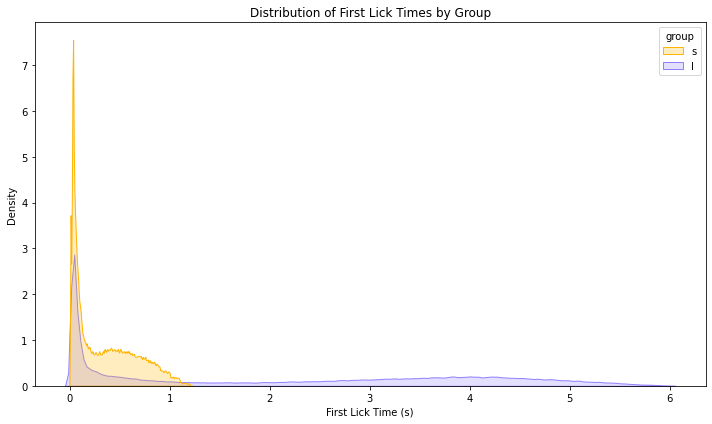

In [58]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=bg_vs_tw[bg_vs_tw['bg_repeats'] > 1],
    x='first_lick',
    hue='group',
    palette=custom_palette,
    common_norm=False,
    fill=True,
    bw_adjust=0.1
)
plt.xlabel('First Lick Time (s)')
plt.ylabel('Density')
plt.title('Distribution of First Lick Times by Group')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "kde_first_lick_by_group_full_range.png"))

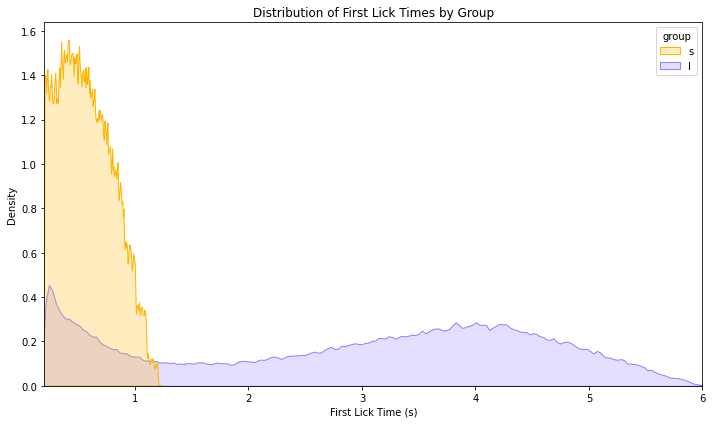

In [59]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=bg_vs_tw[(bg_vs_tw['bg_repeats'] > 1) & (bg_vs_tw['first_lick'] > 0.2)],
    x='first_lick',
    hue='group',
    palette=custom_palette,
    common_norm=False,
    fill=True,
    bw_adjust=0.1
)
plt.xlabel('First Lick Time (s)')
plt.xlim((0.2, 6))
plt.ylabel('Density')
plt.title('Distribution of First Lick Times by Group')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "kde_first_lick_by_group_cropped.png"))

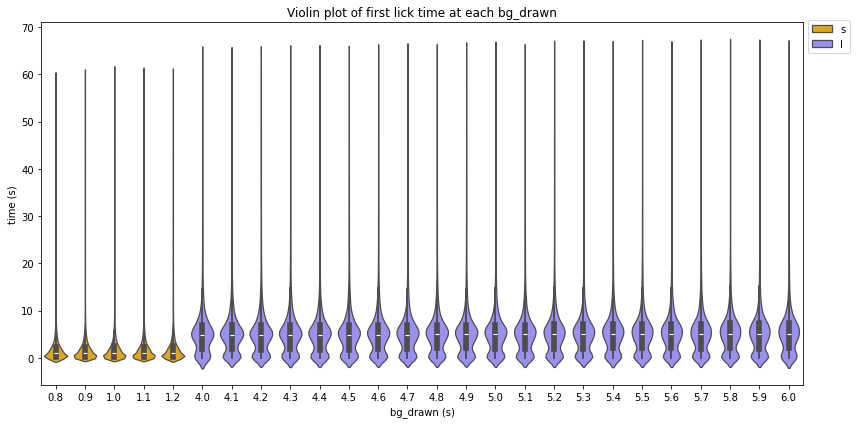

In [60]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='bg_drawn', y='first_lick', hue='group', data=bg_vs_tw, palette=custom_palette)
plt.xlabel('bg_drawn (s)')
plt.ylabel('time (s)')
# plt.ylim((0, 10))
plt.title('Violin plot of first lick time at each bg_drawn')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "violin_bg_drawn_vs_first_lick_time_by_group_all.png"))

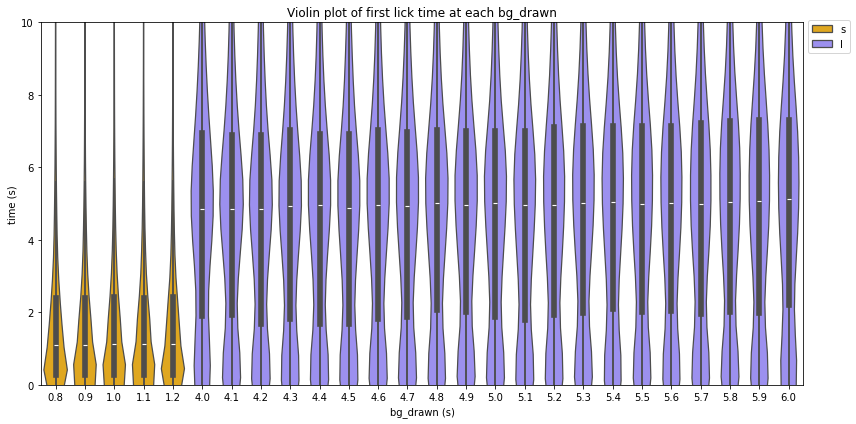

In [61]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='bg_drawn', y='first_lick', hue='group', data=bg_vs_tw, palette=custom_palette)
plt.xlabel('bg_drawn (s)')
plt.ylabel('time (s)')
plt.ylim((0, 10))
plt.title('Violin plot of first lick time at each bg_drawn')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "violin_bg_drawn_vs_first_lick_time_by_group.png"))

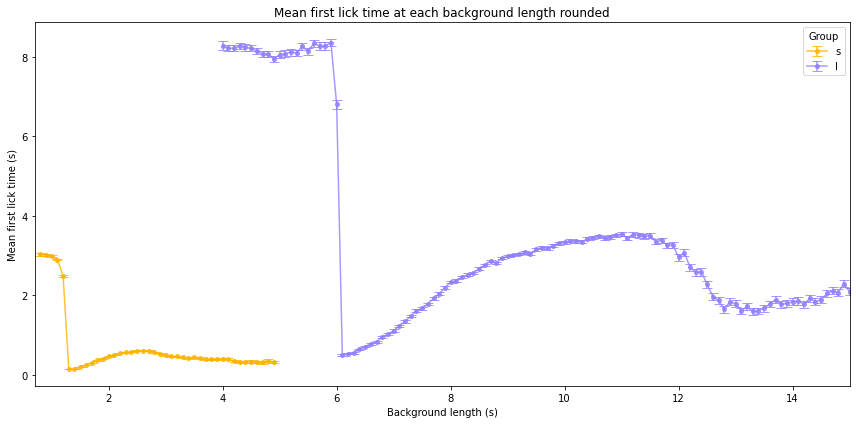

In [62]:
plt.figure(figsize=(12, 6))
grouped = bg_vs_tw.groupby(['bg_length_rounded', 'group'])['first_lick']
mean = grouped.mean().reset_index()
sem = grouped.sem().reset_index()

for group in ['s', 'l']:
    group_mean = mean[mean['group'] == group]
    group_sem = sem[sem['group'] == group]
    plt.errorbar(
        group_mean['bg_length_rounded'],
        group_mean['first_lick'],
        yerr=group_sem['first_lick'],
        label=group,
        color=custom_palette[group],
        fmt='-o',           # line and dot
        capsize=5,
        alpha=0.8,
        markersize=4        # smaller dot
    )

plt.xlabel('Background length (s)')
plt.ylabel('Mean first lick time (s)')
plt.title('Mean first lick time at each background length rounded')
plt.legend(title='Group')
plt.xlim((0.7,15))
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lineplot_mean_first_lick_time_by_bg_length_rounded_cropped.png"))

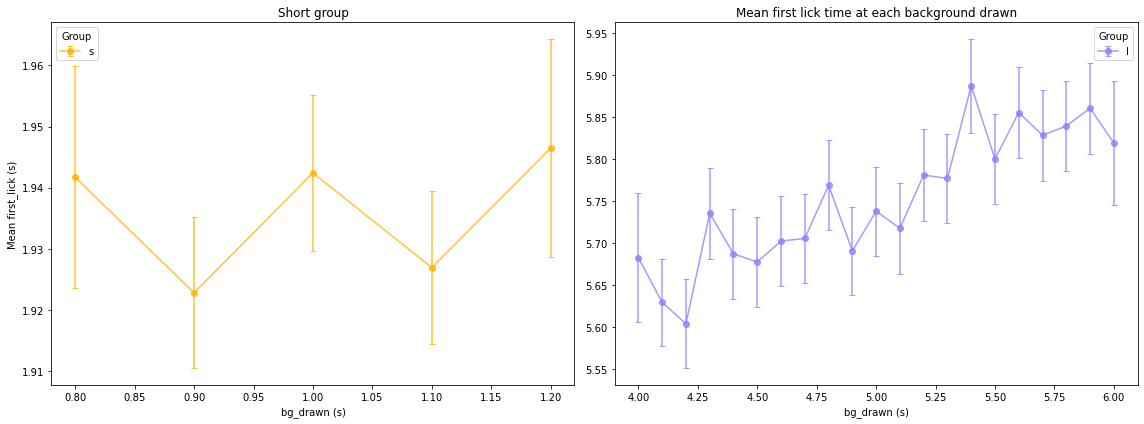

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

grouped = bg_vs_tw.groupby(['bg_drawn', 'group'])['first_lick']
mean = grouped.mean().reset_index()
sem = grouped.sem().reset_index()

for i, group in enumerate(['s', 'l']):
    group_mean = mean[mean['group'] == group]
    group_sem = sem[sem['group'] == group]
    axes[i].errorbar(
        group_mean['bg_drawn'],
        group_mean['first_lick'],
        yerr=group_sem['first_lick'],
        label=group,
        color=custom_palette[group],
        fmt='-o',
        capsize=3,
        alpha=0.8
    )
    axes[i].set_xlabel('bg_drawn (s)')
    axes[i].set_title('Short group' if group == 's' else 'Long group')
    axes[i].legend(title='Group')
axes[0].set_ylabel('Mean first_lick (s)')
plt.title('Mean first lick time at each background drawn')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lineplot_mean_first_lick_time_by_bg_drawn_grouped_split.png"))

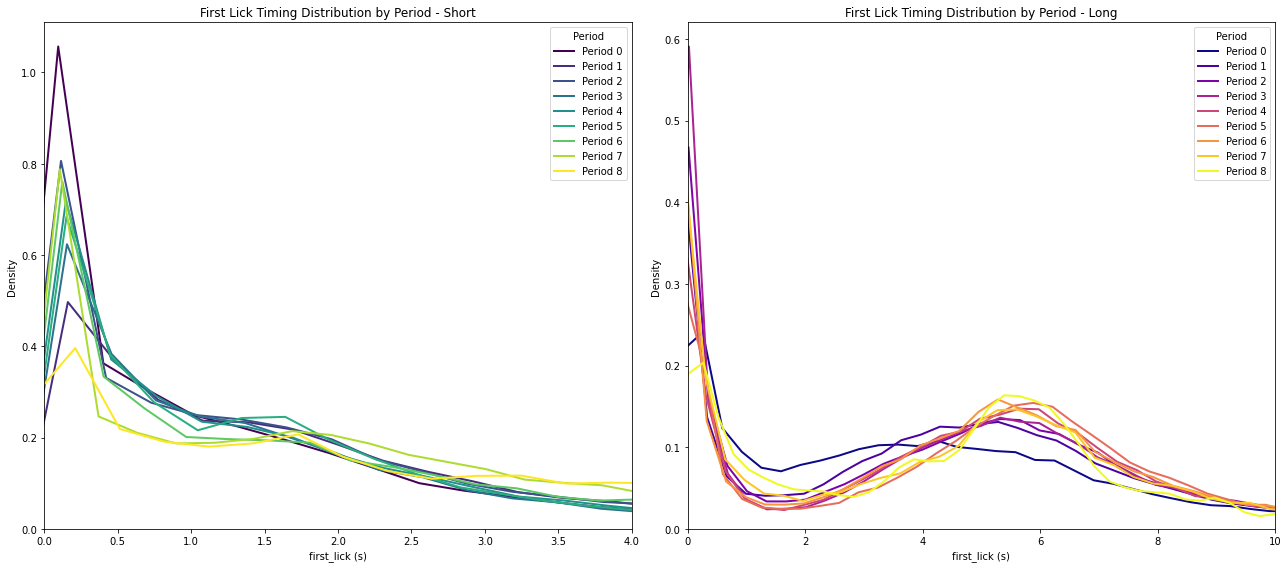

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
periods = sorted(bg_vs_tw['period'].unique())
groups = ['s', 'l']
titles = ['Short', 'Long']
cmaps = [plt.cm.viridis, plt.cm.plasma]
xlims = [(0, 4), (0, 10)]

for i, group in enumerate(groups):
    for period in periods:
        period_data = bg_vs_tw[(bg_vs_tw['group'] == group) & (bg_vs_tw['period'] == period)]
        if not period_data.empty:
            sns.kdeplot(
                data=period_data,
                x='first_lick',
                ax=axes[i],
                label=f'Period {period}',
                linewidth=2,
                bw_adjust=0.15,
                fill=False,
                color=cmaps[i](period / max(periods))
            )
    axes[i].set_title(f'First Lick Timing Distribution by Period - {titles[i]}')
    axes[i].set_xlabel('first_lick (s)')
    axes[i].set_xlim(xlims[i])
    axes[i].set_ylabel('Density')
    axes[i].legend(title='Period')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "kde_first_lick_by_period_short_long.png"))

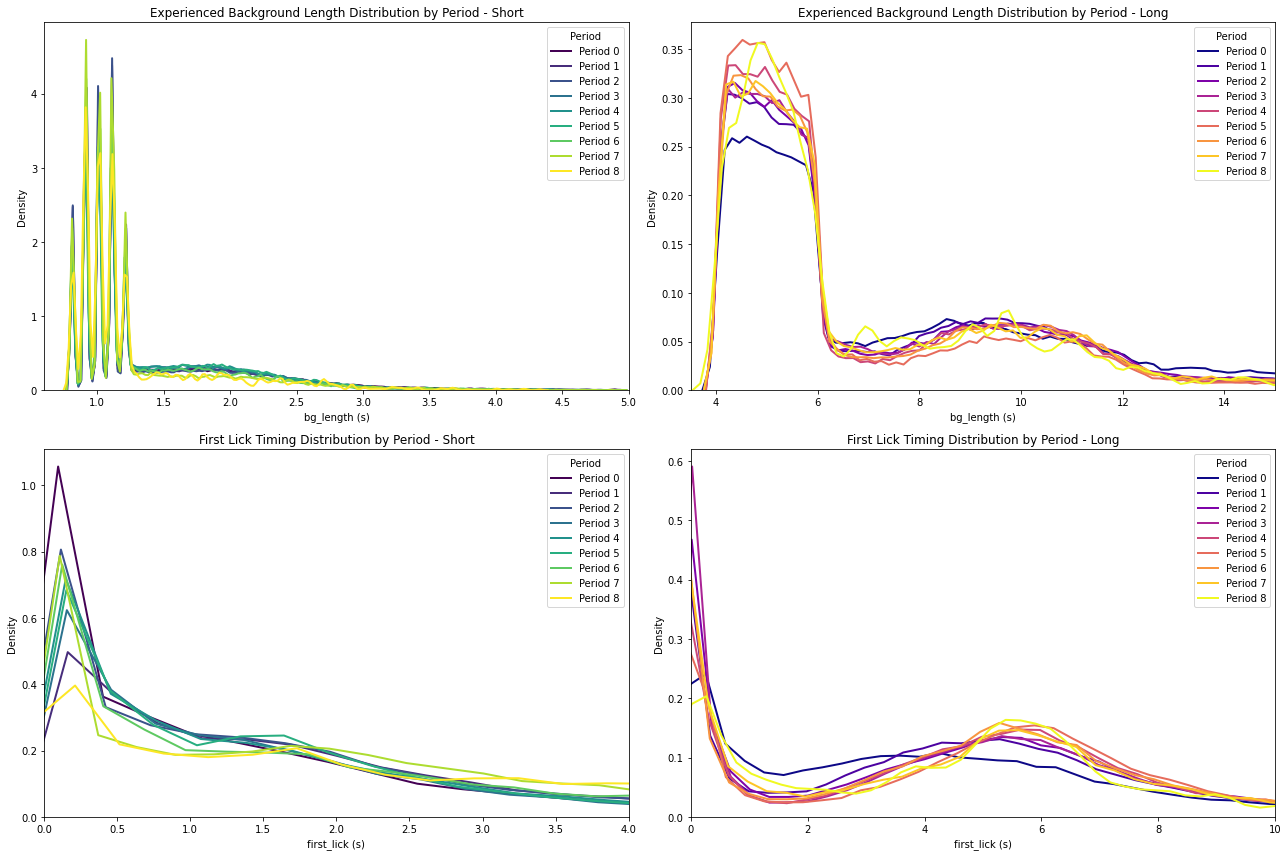

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

periods = sorted(bg_vs_tw['period'].unique())
groups = ['s', 'l']
metrics = [
    {'col': 'bg_length', 'title': 'Experienced Background Length', 'xlims': [(0.6, 5), (3.5, 15)]},
    {'col': 'first_lick', 'title': 'First Lick Timing', 'xlims': [(0, 4), (0, 10)]}
]
cmaps = {'s': plt.cm.viridis, 'l': plt.cm.plasma}
group_names = {'s': 'Short', 'l': 'Long'}

for row, metric in enumerate(metrics):
    for col, group in enumerate(groups):
        ax = axes[row, col]
        group_data = bg_vs_tw[bg_vs_tw['group'] == group]
        
        for period in periods:
            period_data = group_data[group_data['period'] == period]
            if not period_data.empty:
                sns.kdeplot(
                    data=period_data,
                    x=metric['col'],
                    ax=ax,
                    label=f'Period {period}',
                    linewidth=2,
                    bw_adjust=0.15,
                    fill=False,
                    color=cmaps[group](period / max(periods))
                )
        
        ax.set_title(f"{metric['title']} Distribution by Period - {group_names[group]}")
        ax.set_xlabel(f"{metric['col']} (s)")
        ax.set_xlim(metric['xlims'][col])
        ax.set_ylabel('Density')
        ax.legend(title='Period')

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "kde_bg_length_and_first_lick_by_period.png"))

# Lick analysis

In [ ]:
session_info = sessions_training.iloc[22]
events = utils_c5v2.load_data(utils_c5v2.generate_events_processed_path(data_folder, session_info))

In [ ]:
lick_events = events.loc[(events['key']=='lick') & (events['session_time']<(1706993163.500143+50))]
plt.figure(figsize=(20, 3))
plt.step(lick_events['session_time'], lick_events['value'], where='post', linewidth=0.5)
plt.title('Lick Events')
plt.xlabel('Time (s)')
plt.ylabel('Event State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lick_ttl_example_session_22.png"))

In [ ]:
# # Get unique mice
# mice = sessions_training['mouse'].unique()
# n_mice = len(mice)
# fig, axes = plt.subplots(n_mice, 1, figsize=(10, 3 * n_mice), sharex=True)

# for i, mouse in enumerate(mice):
#     mouse_sessions = sessions_training[sessions_training['mouse'] == mouse].sort_values('session')
#     lick_freqs = []
#     session_nums = []
#     for _, session_info in mouse_sessions.iterrows():
#         events = utils_c5v2.load_data(utils_c5v2.generate_events_processed_path(data_folder, session_info))
#         num_licks = events.loc[(events['key'] == 'lick') & (events['value'] == 1)].shape[0]
#         lick_freq = num_licks / session_info['session_time']
#         lick_freqs.append(lick_freq)
#         session_nums.append(session_info['session'])
#     axes[i].plot(session_nums, lick_freqs, marker='o')
#     axes[i].set_title(f'Mouse: {mouse}')
#     axes[i].set_ylabel('Lick Frequency (Hz)')
# axes[-1].set_xlabel('Session')
# plt.tight_layout()
# plt.show()

In [ ]:
mice = sessions_training['mouse'].unique()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for i, group in enumerate(['s', 'l']):
    for mouse in mice:
        mouse_sessions = sessions_training[(sessions_training['mouse'] == mouse) & (sessions_training['group'] == group)].sort_values('session')
        lick_freqs = []
        session_nums = []
        for _, session_info in mouse_sessions.iterrows():
            events = utils_c5v2.load_data(utils_c5v2.generate_events_processed_path(data_folder, session_info))
            num_licks = events.loc[(events['key'] == 'lick') & (events['value'] == 1)].shape[0]
            lick_freq = num_licks / session_info['session_time']
            lick_freqs.append(lick_freq)
            session_nums.append(session_info['session'])
        axes[i].plot(session_nums, lick_freqs, marker='o', alpha=0.5, label=mouse)
    axes[i].set_xlabel('Session')
    axes[i].set_title('Short group' if group == 's' else 'Long group')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
axes[0].set_ylabel('Lick Frequency (Hz)')
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "lick_frequency_by_mouse_and_group.png"))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for group in ['s', 'l']:
    group_data = []
    session_nums = []
    for mouse in mice:
        mouse_sessions = sessions_training[(sessions_training['mouse'] == mouse) & (sessions_training['group'] == group)].sort_values('session')
        lick_freqs = []
        session_ids = []
        for _, session_info in mouse_sessions.iterrows():
            events = utils_c5v2.load_data(utils_c5v2.generate_events_processed_path(data_folder, session_info))
            num_licks = events.loc[(events['key'] == 'lick') & (events['value'] == 1)].shape[0]
            lick_freq = num_licks / session_info['session_time']
            lick_freqs.append(lick_freq)
            session_ids.append(session_info['session'])
        if lick_freqs:
            group_data.append(lick_freqs)
            session_nums.append(session_ids)
    # Compute mean lick frequency per session index across mice
    if session_nums:
        # Find the max session length for alignment
        max_len = max(len(s) for s in session_nums)
        # Pad with np.nan for alignment
        lick_freqs_padded = [np.pad(lf, (0, max_len - len(lf)), constant_values=np.nan) for lf in group_data]
        lick_freqs_array = np.vstack(lick_freqs_padded)
        mean_lick_freq = np.nanmean(lick_freqs_array, axis=0)
        sem_lick_freq = np.nanstd(lick_freqs_array, axis=0) / np.sqrt(np.sum(~np.isnan(lick_freqs_array), axis=0))
        # Use session indices from 0 to max_len-1
        ax.errorbar(range(max_len), mean_lick_freq, yerr=sem_lick_freq, label='Short' if group == 's' else 'Long', color=custom_palette[group], marker='o', capsize=4, alpha=0.8)

ax.set_xlabel('Session')
ax.set_ylabel('Lick Frequency (Hz)')
ax.set_title('Mean Lick Frequency per Session (Short vs Long)')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "mean_lick_frequency_per_session_short_vs_long.png"))

In [ ]:
session_info = sessions_training.iloc[22]
events = utils_c5v2.load_data(utils_c5v2.generate_events_processed_path(data_folder, session_info))
licks = events.loc[events['key']=='lick']
lick_starts = licks[licks['value'] == 1]['session_time'].reset_index(drop=True)
lick_starts_dt = pd.to_datetime(lick_starts, unit='s')
time_diffs = lick_starts_dt.diff().dt.total_seconds()

plt.figure(figsize=(10, 6))
sns.histplot(time_diffs.dropna(), bins=100, kde=True, color="#4a90e2")
plt.xlabel('Time between licks (s)')
plt.ylabel('Count')
plt.title('Distribution of Time Differences Between Licks')
plt.tight_layout()
plt.show()

In [ ]:
def remove_outliers(series, z_thresh=3):
    z_scores = (series - series.mean()) / series.std()
    return series[abs(z_scores) < z_thresh]

In [ ]:
for _, session_info in sessions_training.iterrows():
    events = utils_c5v2.load_data(utils_c5v2.generate_events_processed_path(data_folder, session_info))
    licks = events.loc[events['key']=='lick']
    lick_starts = licks[licks['value'] == 1]['session_time'].reset_index(drop=True)
    lick_starts_dt = pd.to_datetime(lick_starts, unit='s')
    time_diffs = lick_starts_dt.diff().dt.total_seconds()
    # time_diffs_no_outliers = remove_outliers(time_diffs.dropna())
    time_diffs_close = time_diffs.loc[time_diffs < 10].dropna()  # Filter for time differences less than 10 seconds
    
    plt.figure(figsize=(10, 6))
    sns.histplot(time_diffs_close, bins=100, kde=True, color="#4a90e2")
    plt.xlabel('Time between licks (s)')
    plt.xlim((0, 10))  # Limit x-axis to focus on shorter intervals
    plt.ylabel('Count')
    plt.title(f"lick_distributions_{session_info['dir']}.png")
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, "lick_distributions", f"lick_distributions_{session_info['dir']}.png"))
    plt.close()  # Close the figure to avoid display in notebook

In [ ]:
events = utils_c5v2.load_data(utils_c5v2.generate_events_processed_path(data_folder, session_info))
consumption_times = events[(events['key'] == 'consumption') & (events['value'] == 1)][['session_trial_num', 'trial_time']]
events_aligned = pd.merge(events, consumption_times, on='session_trial_num', suffixes=('', '_consumption'), how='left')
events_aligned['to_consumption'] = events_aligned['trial_time'] - events_aligned['trial_time_consumption']
events_aligned = events_aligned.drop(columns=['trial_time_consumption'])

In [ ]:
licks_reward = events_aligned.loc[(events_aligned['state']=='in_consumption') & (events_aligned['key']=='lick') & (events_aligned['value']==1)]

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(
    licks_reward['to_consumption'],
    bins=100,
    kde=True,
    color="#ffb400"
)
plt.xlabel('Trial Time (s)')
plt.ylabel('Count')
plt.title('Distribution of Reward Licks Over Trial Time')
plt.tight_layout()
plt.show()

In [ ]:
for _, session_info in sessions_training.iterrows():
    events = utils_c5v2.load_data(utils_c5v2.generate_events_processed_path(data_folder, session_info))
    consumption_times = events[(events['key'] == 'consumption') & (events['value'] == 1)][['session_trial_num', 'trial_time']]
    events_aligned = pd.merge(events, consumption_times, on='session_trial_num', suffixes=('', '_consumption'), how='left')
    events_aligned['to_consumption'] = events_aligned['trial_time'] - events_aligned['trial_time_consumption']
    events_aligned = events_aligned.drop(columns=['trial_time_consumption'])
    licks_reward = events_aligned.loc[(events_aligned['state']=='in_consumption') & (events_aligned['key']=='lick') & (events_aligned['value']==1)]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(
        licks_reward['to_consumption'],
        bins=100,
        kde=True,
        color="#ffb400"
    )
    plt.xlabel('Trial Time (s)')
    plt.ylabel('Count')
    plt.title(f'Distribution of Reward Licks - {session_info["dir"]}')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, "reward_licks_distribution", f"reward_licks_distribution_{session_info['dir']}.png"))
    plt.close()  # Close the figure to avoid display in notebook

# one plot for each mouse

In [ ]:
def get_mouse_bg_drawn_and_time_waited(mouse_data):
    bg_drawn_all = []
    time_waited_all = []
    for _, row in mouse_data.iterrows():
        trials_path = utils_c5v2.generate_trials_analyzed_path(data_folder, row)
        trials = utils_c5v2.load_data(trials_path)
        bg_drawn_all.append(trials.bg_drawn)
        time_waited_all.append(trials.time_waited)

    bg_drawn_all_flat = pd.concat(bg_drawn_all, ignore_index=True)
    time_waited_all_flat = pd.concat(time_waited_all, ignore_index=True)

    # Remove NaN values from bg_drawn_all_flat and time_waited_all_flat, keeping only matching indices
    mask = ~time_waited_all_flat.isna()
    bg_drawn_clean = bg_drawn_all_flat[mask]
    time_waited_clean = time_waited_all_flat[mask]
    return bg_drawn_clean, time_waited_clean

In [ ]:
def linear_regression(x, y):
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    linear_regression_result = {
        'slope': slope,
        'intercept': intercept,
        'r2': r_val**2,
        'p_val': p_val,
        'std_err': std_err,
        'N': len(x)
    }
    return linear_regression_result

In [ ]:
def plot_scatter_with_linear_regression(x, y, lin_reg_result, mouse, group):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5, s=8, color=custom_palette[group])

    # Plot linear regression line using slope and intercept from linregress
    x_vals = np.array([x.min(), x.max()])
    y_vals = lin_reg_result['slope'] * x_vals + lin_reg_result['intercept'] 
    plt.plot(x_vals, y_vals, color='black', linewidth=2)
    # Add regression stats as text on the plot
    stats_text = (
        f"y = {lin_reg_result['slope']:.3f} t + {lin_reg_result['intercept']:.3f}\n"
        f"R²: {lin_reg_result['r2']:.3f}\n"
        f"p-val: {lin_reg_result['p_val']:.2e}\n"
        f"N: {lin_reg_result['N']}"
    )
    plt.gca().text(
        0.98, 0.98, stats_text,
        transform=plt.gca().transAxes,
        fontsize=11, va='top', ha='right',
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.8)
    )

    plt.xlabel('bg_drawn')
    plt.ylabel('time_waited')
    plot_title = f'bg_drawn_vs_time_waited_{mouse}'
    plt.title(plot_title)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, f"{plot_title}.png"))
    plt.close()

In [ ]:
# Group sessions_training by mouse and perform the analysis for each mouse
for mouse, mouse_data in sessions_training.groupby('mouse'):
    bg_drawn, time_waited = get_mouse_bg_drawn_and_time_waited(mouse_data)
    lin_reg_result = {"mouse": mouse} | linear_regression(bg_drawn, time_waited)
    plot_scatter_with_linear_regression(bg_drawn, time_waited, lin_reg_result, mouse, mouse_data['group'].iloc[0])

# modeling wait time

In [ ]:
bg_vs_tw['z_time'] = bg_vs_tw['bg_length'] + bg_vs_tw['time_waited']

In [ ]:
# Summary statistics for z_time
print("Summary Statistics for z_time:")
print("=" * 40)
print(f"Count: {bg_vs_tw['z_time'].count()}")
print(f"Mean: {bg_vs_tw['z_time'].mean():.3f}")
print(f"Std: {bg_vs_tw['z_time'].std():.3f}")
print(f"Min: {bg_vs_tw['z_time'].min():.3f}")
print(f"25%: {bg_vs_tw['z_time'].quantile(0.25):.3f}")
print(f"50% (Median): {bg_vs_tw['z_time'].median():.3f}")
print(f"75%: {bg_vs_tw['z_time'].quantile(0.75):.3f}")
print(f"Max: {bg_vs_tw['z_time'].max():.3f}")

print("\nSummary by Group:")
print("=" * 40)
for group in ['s', 'l']:
    group_data = bg_vs_tw[bg_vs_tw['group'] == group]['z_time']
    print(f"\n{group.upper()} Group:")
    print(f"  Count: {group_data.count()}")
    print(f"  Mean: {group_data.mean():.3f}")
    print(f"  Std: {group_data.std():.3f}")
    print(f"  Min: {group_data.min():.3f}")
    print(f"  Median: {group_data.median():.3f}")
    print(f"  Max: {group_data.max():.3f}")

# Detailed summary using pandas describe
print("\nDetailed Summary (pandas describe):")
print("=" * 40)
print(bg_vs_tw['z_time'].describe())

print("\nDetailed Summary by Group:")
print("=" * 40)
print(bg_vs_tw.groupby('group')['z_time'].describe())

In [ ]:
# Import sklearn dummy predictor and train it to predict z_time
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Prepare features for prediction
# Select relevant features that could predict z_time
feature_columns = ['bg_length', 'bg_drawn', 'time_waited', 'bg_repeats', 'period']
categorical_columns = ['group', 'good_trial']

# Create feature matrix X and target variable y
X = bg_vs_tw[feature_columns + categorical_columns].copy()
y = bg_vs_tw['z_time']

# Handle categorical variables by one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Remove any rows with NaN values
mask = ~(X_encoded.isna().any(axis=1) | y.isna())
X_clean = X_encoded[mask]
y_clean = y[mask]

print(f"Data shape after cleaning: X={X_clean.shape}, y={y_clean.shape}")
print(f"Features used: {list(X_clean.columns)}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train different dummy regressors
dummy_models = {
    'mean': DummyRegressor(strategy='mean'),
    'median': DummyRegressor(strategy='median'),
    'constant': DummyRegressor(strategy='constant', constant=5.0),
    'quantile': DummyRegressor(strategy='quantile', quantile=0.75)
}

results = {}

for name, model in dummy_models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'predictions': y_pred
    }
    
    print(f"\n{name.upper()} Dummy Regressor:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")

# Compare with actual z_time statistics
print(f"\nActual z_time statistics:")
print(f"  Mean: {y_clean.mean():.4f}")
print(f"  Median: {y_clean.median():.4f}")
print(f"  Std: {y_clean.std():.4f}")
print(f"  75th percentile: {y_clean.quantile(0.75):.4f}")

# Plot predictions vs actual values
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, result) in enumerate(results.items()):
    ax = axes[i]
    
    # Scatter plot of predicted vs actual
    ax.scatter(y_test, result['predictions'], alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_test.min(), result['predictions'].min())
    max_val = max(y_test.max(), result['predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
    
    ax.set_xlabel('Actual z_time')
    ax.set_ylabel('Predicted z_time')
    ax.set_title(f'{name.title()} Dummy Regressor\nR² = {result["R²"]:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figure_folder, "dummy_regressor_predictions.png"))
plt.show()

# Summary table of results
results_df = pd.DataFrame({
    name: {k: v for k, v in result.items() if k != 'predictions'}
    for name, result in results.items()
}).T

print("\nSummary of Dummy Regressor Performance:")
print("=" * 50)
print(results_df.round(4))